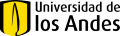

<span style="font-family:Cambria Math">
    
# Micro-proyecto 1. Generación de paleta de colores a partir de imágenes con técnicas de *machine learning* no supervisado

## Contexto
Este proyecto busca desarrollar una aplicación basada en *machine learning* que permita generar automáticamente paletas de colores a partir de imágenes. Esta herramienta ayudará a diseñadores, artistas y creadores de contenido a seleccionar combinaciones cromáticas armoniosas y funcionales de manera rápida y eficiente. La aplicación identificará los tonos dominantes y analizará sus relaciones cromáticas para crear paletas visualmente atractivas, optimizando la calidad y el impacto de la comunicación visual en diversos campos como el diseño, el arte, la psicología y el marketing.

***

También este micro-proyecto busca retar a los estudiantes para aplicar los conocimientos adquiridos en las semanas 1-4 del curso "*Machine Learning* No Supervisado".

***

## Objetivo
Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de
una imagen y generar un muestrario de los colores presentes en esta
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Núñez Campos para entrega el 24 de febrero.**
</div24></span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**1. Utilizar la heurística para encontrar los mejores epsilon y min samples** , Pensar en usar HDBSCAN y Índice DBCV (Density-based Clustering Validation):(Responsable: Andrés) ✔️

**2.Visualización t-SNE** (Responsable: Andrés, hablarlo con los monitores, profesora) ✔️

**3. Implementar Aglomerativo** (Responsable: Jordan) ✔️

**4. Visualización de las siluetas** (Responsable: Jordan)

**5. Descripciones, textos, justificaciones** (Responsable: Jordan, Andrés)


</div24></span>

***

<span style="font-family:Cambria Math">

# Desarrollo
## Librerías requeridas
Cargamos las librerias necesarias para la preparación y procesamiento de los datos, y visualización de resultados. Se destaca que dentro de las importaciones se incluyen los modelos utilizados más adelante (`KMeans`, `MeanShift`, `DBSCAN`, `HDBSCAN` y `AgglomerativeClustering`). Adicionalmente, se usa un algoritmo `Nearest Neighbors`, pero únicamente como ayuda heurística para detectar los parámetros adecuados del algoritmo `DBSCAN`.
</span>

In [1]:
!pip install kneed

In [2]:
pip install hdbscan

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Librerias de preparación de los datos y gráficos
from skimage import io, color, transform
from skimage.transform import rescale
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # para los plots 3D
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Los diferentes modelos de ML usados
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors

#Otros algoritmos de visualización
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE

#Libreria usada para detectar el codo automáticamente
from kneed import KneeLocator

#Otros, joblib permite paralelizar procesos para acelerar el ajuste de los modelos
from joblib import Parallel, delayed
from itertools import cycle

***

<span style="font-family:Cambria Math">

También es importante dejar explícitas las versiones usadas de cada libreria, para efectos de que este proyecto pueda ser replicado más adelante.
</span>

In [4]:
from importlib.metadata import version
version('scikit-image')
#Librerias usadas
for library in ['scikit-image', 'matplotlib', 'numpy','Pandas','matplotlib','hdbscan','kneed', 'scikit-learn', 'scipy']:
  print(library, ": ", version(library))

scikit-image :  0.25.1
matplotlib :  3.10.0
numpy :  2.2.1
Pandas :  2.2.3
matplotlib :  3.10.0
hdbscan :  0.8.40
kneed :  0.8.5
scikit-learn :  1.6.0
scipy :  1.14.1


***

<span style="font-family:Cambria Math">

## Imágenes seleccionadas

A continuación se muestra la selección de pinturas para este micro-proyecto.

</span>

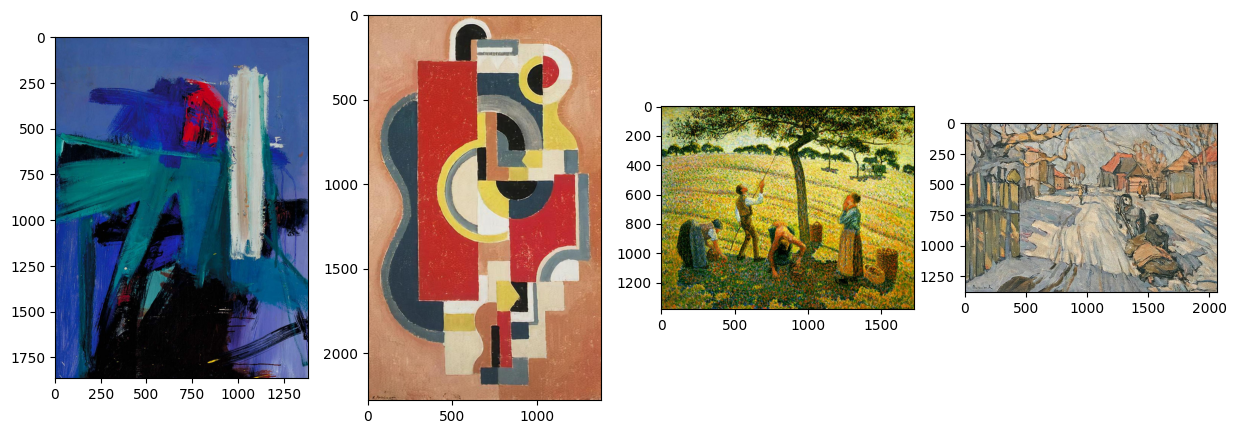

In [5]:
#Blueberry Eyes, Franz Kline (1960)
img1 = "img/franz-kline_blueberry-eyes-1960.jpg"
#Hommage à Delaunay et Gleizes, Adolf Fleischmann (1938) 
img2 = "img/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg"
#Apple Picking at Eragny-sur-Epte, Camille Pissarro (1888)
img3 = "img/camille-pissarro_apple-picking-at-eragny-sur-epte-1888.jpg"
#Troika in the Snow, Abraham Manievich (1910)
img4 = "img/abraham-manievich_troika-in-the-snow-1910.jpg"

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i, imgpath in enumerate([img1, img2, img3, img4]):
    ax[i].imshow(io.imread(imgpath))

<span style="font-family:Cambria Math">

Dentro de la preparación de los datos se eligió transformar los pixeles al espacio de color CIELAB. A continuación se explica con un poco más de detalle de qué se trata este modelo.

## El espacio de color CIELAB

El espacio de color CIELAB es un modelo cromático usado para describir todos los colores que puede percibir el ojo humano (`rojo`, `verde`, `azul` y `amarillo`), además de la `luminosidad`. De este modo, CIELAB tiene la intención de mimetizar la respuesta no lineal del sistema visual, lo que resulta adecuado para la extracción de una paleta de colores.

Este espacio cromático hace uso de tres dimensiones:
- Luminosidad `L*` (negro a blanco), con rango continuo `0:100`
- Eje verde-rojo `a*`, con rango continuo `-128:127`
- Eje azul-amarillo `a*`, con rango continuo `-128:127`
  
Por lo tanto, el cálculo de distancias euclidianas entre puntos 3D es válido en este espacio.

La función `color.rgb2lab` de la librería `skimage` permite transformar un espacio de color RGB a uno CIELAB. Algunos detalles:
- Un argumento importante de esta función es `illuminant`, que determina el criterio de iluminación. La opción por defecto para este argumento es `'D65'`, y es la que se suele recomendar y utilizar en la industria de la imprenta.
- `color.rgb2lab` realiza la conversión entre RGB y CIELAB de forma segura, manejando los rangos apropiadamente.

A continuación se muestra un ejemplo de cómo se realiza esta transformación:
</span>

In [6]:
rgb_test = np.array([100, 17, 125]).astype(np.uint8)
color.rgb2lab(rgb_test)
# Se puede corroborar que coincide con los resulados de http://colormine.org/convert/rgb-to-lab

array([ 25.53664668,  50.17476414, -41.6948955 ])

***

<span style="font-family:Cambria Math">

## Preprocesamiento de datos

Utilizaremos un enfoque procedimental para la preparación de datos (y en general, para la construcción de todo el pipeline). Es decir, definiremos múltiples funciones que no serán utilizadas sino hasta la etapa de ejecución de los algoritmos de agrupación. Esto se realiza con el objetivo de probar distintos modelos y evitar la redundancia en el código.

### Pipeline de preprocesamiento

Para la construcción del pipeline de pre-procesamiento de los datos hay que considerar que estamos trabajando con imágenes, por lo tanto los *outliers* podrían ser informativos. También hay que tener en cuenta que, para el correcto funcionamiento de los modelos, es recomendado tener los datos estandarizados, por ello utilizaremos un `StandardScaler`.

También es necesario re-escalar la resolución de las imágenes, y para ello utilizaremos la función `rescale` de la librería `skimage`. Esto permite un mejor uso de los recursos de procesamiento, ya que al final cada pixel se convertirá en un dato, por lo que se debe usar un número de píxeles adecuado que permita realizar la tarea de agrupación pero que no exija muchos recursos de cómputo. Nos aseguramos de mantener el rango de colores original que es lo que más nos interesa para efecto de la construcción de la paleta de colores, y se realiza un "suavizado" durante el escalado ya que cuando se reduce el tamaño de una imagen, se pueden tener efectos no deseados como el *aliasing* (escalones o bordes dentados). Con el parámetro `anti_aliasing=True` se aplica un filtro de suavizado Gaussiano antes del escalado, reduciendo estos defectos. Esta operación modifica ligeramente los colores originales de la imagen

A continuación se definen las funciones del pipeline de preprocesamiento:
</span>

In [7]:
# Downsampling
def reescalar_img(img: np.ndarray, factor: float):
    img_rescaled = rescale(
        img,
        scale=factor,
        channel_axis=2, #especificar cuál es el canal de colores
        preserve_range=True, #mantener el rango de colores original
        anti_aliasing=True, #suavizar durante el escalado 
        order = 0, # valor por defecto
    )
    return img_rescaled.astype(img.dtype)

***
<span style="font-family:Cambria Math">

Se utiliza el comando `imread` de `skimage.io` para cargar la imagen y después de re-escalarla se hace la transformación de la imágen para tenerla en formato RGB y CIELAB

</span>

In [8]:
# Cargar img reescalada en ambos espacios de color: RGB y LAB
def cargar_img_RGB_LAB_downsample(imgpath: str, factor: float = 0.25):
    img = io.imread(imgpath)
    rgb = reescalar_img(img, factor)
    lab = color.rgb2lab(rgb)
    return img, rgb, lab

***
<span style="font-family:Cambria Math">

También es necesario re-estructurar los datos para poder trabajar los pixeles como filas y los canales como columnas:

</span>

In [9]:
# Obtener data tabular: pixeles como filas y CIELAB como columnas
def img_to_tabular(img: np.ndarray):
    return img.reshape(-1, img.shape[-1])

***
<span style="font-family:Cambria Math">

Se definen las funciones de estandarización y su respectiva inversa, para más adelante usarla en cada corrida del modelo. Esto se incorporará en el *pipeline* del modelo por facilidad.

</span>

In [10]:
def estandarizar(X: np.ndarray):
    scaler = StandardScaler()
    return scaler.fit_transform(X), scaler

In [11]:
def des_estandarizar(X: np.ndarray, scaler: object):
     return scaler.inverse_transform(X)

***
<span style="font-family:Cambria Math">

## Análisis Exploratorio

El siguiente plot nos permite tener una idea básica de la distribución de los datos en ambos espacios de características 3D: RGB y LAB

</span>

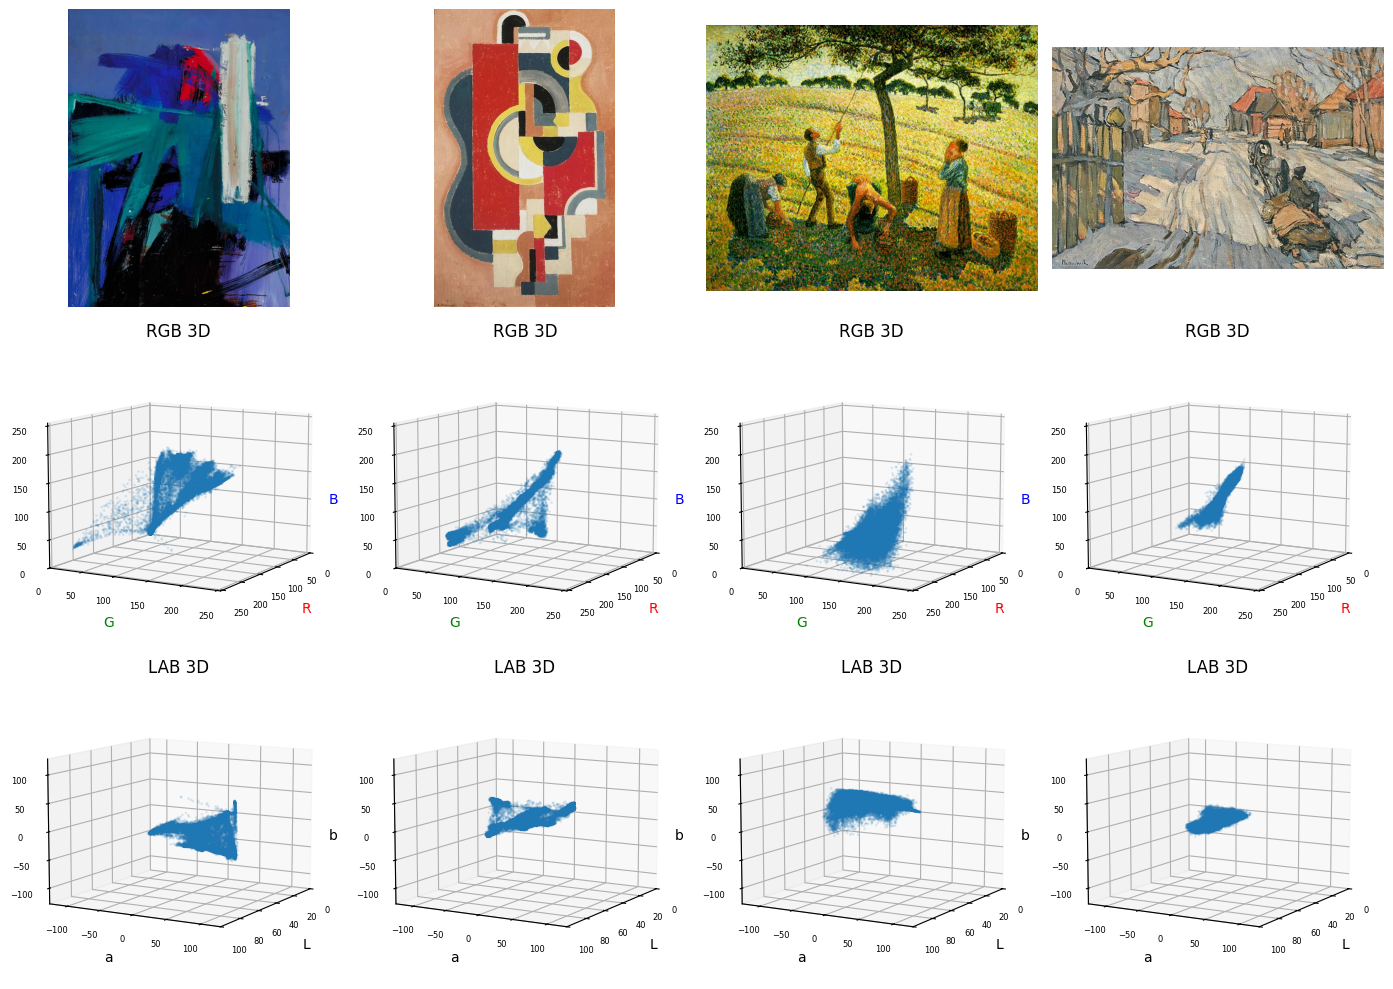

In [12]:
fig, ax = plt.subplots(3, 4, figsize=(14, 10))

for row in [1, 2]:
    for i in range(4):
        fig.delaxes(ax[row, i])
        pos = row * 4 + i + 1
        ax[row, i] = fig.add_subplot(3, 4, pos, projection='3d')
        ax[row, i].tick_params(axis='both', which='major', labelsize=6)
        ax[row, i].view_init(elev=10., azim=30)

for i, imgpath in enumerate([img1, img2, img3, img4]):
    img, rgb, lab = cargar_img_RGB_LAB_downsample(imgpath, factor=0.10)
    
    ax[0, i].imshow(img)
    ax[0, i].axis('off')

    ax[1, i].scatter(*img_to_tabular(rgb).T, alpha=0.10, s=1)
    ax[1, i].set_title("RGB 3D")
    ax[1, i].set_xlim3d(left=0, right=255)
    ax[1, i].set_ylim3d(bottom=0, top=255) 
    ax[1, i].set_zlim3d(bottom=0, top=255)
    ax[1, i].set_xlabel("R", color='red')
    ax[1, i].set_ylabel("G", color='green')
    ax[1, i].set_zlabel("B", color='blue')
    
    ax[2, i].scatter(*img_to_tabular(lab).T, alpha=0.10, s=1)
    ax[2, i].set_title("LAB 3D")
    ax[2, i].set_xlim3d(left=0, right=100)
    ax[2, i].set_ylim3d(bottom=-128, top=128) 
    ax[2, i].set_zlim3d(bottom=-128, top=128)
    ax[2, i].set_xlabel("L")
    ax[2, i].set_ylabel("a")
    ax[2, i].set_zlabel("b")

plt.tight_layout()
plt.show()

Una animación de giro de cámara nos permite un análisis más dinámico. Este `gif` fue obtenido a partir de la unión de múltiples imágenes generadas con la función `plt.saveimage()`.

<img src="clip.gif" width="750" align="center">

***
<span style="font-family:Cambria Math">

## Modelos de Clustering

Los modelos que utilizaremos son los siguientes:
- Kmeans
- Mean Shift
- DBSCAN
- HDBSCAN
- Jerárquico Aglomerativo

La principal métrica que utilizaremos será **silhouette score** 🔨 (y quizá silhouette diagram).

Siguiendo nuestro enfoque del pipeline procedimental, se crean 4 funciones que nos permitirán identificar los coeficientes de silueta de estos modelos pasando por un número de grupos de entre 5 y 7, de acuerdo a las consideraciones del microproyecto (pero dependiendo de la particularidad de cada modelo, ya que en algunos no se puede dar por parámetro el número de *clusters*).

</span>

***
<span style="font-family:Cambria Math">

### KMeans

</span>

In [13]:
# Selección de Kmeans con base en silhouette_score
def KMeans_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7, visuals: bool = True):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Ajuste de modelos en paralelo para mejorar velocidad
    def entrenar_kmeans(k):
        modelo = KMeans(n_clusters=k, max_iter=300, n_init="auto", random_state=42)
        labels = modelo.fit_predict(X)
        score = silhouette_score(X, labels)
        return modelo, score

    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_kmeans)(k) for k in range(Kmin, Kmax + 1)
    )

    # Obtener el mejor modelo basado en el Silhouette Score
    modelos, silhouette_scores = zip(*resultados)
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]

    # Desestandarizar centroides
    centroides = des_estandarizar(mejor_modelo.cluster_centers_, scaler)
    centroides_no_reshape = color.lab2rgb(centroides)
    centroids_RGB_img = centroides_no_reshape.reshape((1, mejor_modelo.n_clusters, 3))

    # Imprimir resultados
    if visuals:
      for k, score in zip(range(Kmin, Kmax + 1), silhouette_scores):
          print(f"Modelo KMeans K={k} --> Silhouette Score: {score:.4f}")

      print("**Mejor modelo KMeans**")
      print(f"Número de clusters: {mejor_modelo.n_clusters}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

### MeanShift

</span>

In [14]:
# Definición de Función para la fase entrenamiento
def entrenar_meanshift(X, quantile):
    #Entrena un modelo MeanShift y devuelve el modelo, número de clusters y Silhouette Score
    bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=100)
    modelo = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    modelo.fit(X)
    n_clusters = len(modelo.cluster_centers_)

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, modelo.labels_) if n_clusters > 1 else -1

    return modelo, n_clusters, quantile, score
# Selección de MeanShift con base en silhouette_score
def MeanShift_silhouette(X: np.ndarray, quantiles: list, visuals: bool = True):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar el entrenamiento de modelos
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_meanshift)(X, q) for q in quantiles
    )

    # Extraer resultados
    modelos, clusters, quantiles_usados, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    if visuals:
      for k, q, score in zip(clusters, quantiles_usados, silhouette_scores):
          print(f"Modelo MeanShift K={k} Quantile={q} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]

    # Obtener centroides y convertirlos a RGB
    n = mejor_modelo.cluster_centers_.shape[0]
    centroides = des_estandarizar(mejor_modelo.cluster_centers_, scaler)
    centroides_no_reshape = color.lab2rgb(centroides)
    centroids_RGB_img = centroides_no_reshape.reshape((1, n, 3))

    # Imprimir información del mejor modelo
    if visuals:
      print("**Mejor modelo MeanShift**")
      print(f"Número de clusters: {n} Quantile={quantiles_usados[mejor_idx]}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

### DBSCAN

</span>

In [15]:
# Definición de Función para la fase entrenamiento
def entrenar_dbscan(X, eps, min_samples, metric):
    #Entrena DBSCAN y devuelve el modelo, número de clusters y Silhouette Score.
    modelo = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    labels = modelo.fit_predict(X)

    # Filtrar ruido (-1) y calcular número de clusters reales
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels[unique_labels != -1])  # Excluir ruido

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, labels) if num_clusters > 1 else -1

    return modelo, num_clusters, eps, min_samples, score
# Selección de DBSCAN con base en silhouette_score
def DBSCAN_silhouette(X: np.ndarray, eps_list: list, min_samples_list: list, metric: str ='euclidean',visuals: bool = True):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar la búsqueda de hiperparámetros
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_dbscan)(X, eps, min_samples, metric)
        for eps in eps_list for min_samples in min_samples_list
    )

    # Extraer resultados
    modelos, num_clusters, eps_values, min_samples_values, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    if visuals:
      for k, eps, min_samples, score in zip(num_clusters, eps_values, min_samples_values, silhouette_scores):
          print(f"Modelo DBSCAN K={k} Epsilon={eps} Min Samples={min_samples} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]
    mejor_eps = eps_values[mejor_idx]
    mejor_min_samples = min_samples_values[mejor_idx]

    # Obtener labels y filtrar ruido (-1)
    labels = mejor_modelo.labels_
    valid_labels = labels != -1  # Excluir puntos de ruido
    unique_labels = np.unique(labels[valid_labels])

    # Calcular "centroides" como el promedio de los core points por cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    centroids = des_estandarizar(centroids, scaler)

    # Convertir a imagen RGB
    mejor_k = len(centroids)
    centroides_no_reshape = color.lab2rgb(centroids)
    centroids_RGB_img = centroides_no_reshape.reshape((1, mejor_k, 3))

    # Imprimir información del mejor modelo
    if visuals:
      print("**Mejor modelo DBSCAN**")
      print(f"Número de clusters: {mejor_k} | Epsilon: {mejor_eps} | Min Samples: {mejor_min_samples}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

#### Consideraciones para el algoritmo DBSCAN

Para el algoritmo de DBSCAN se prueban las heurísticas explicada en el curso para hallar tanto min_samples como eps. En nuestro caso, el número de características del conjunto de datos es 3, por lo que se aconseja un `min_samples` mayor o igual a 4. Cuando hay mucha dispersión este valor debería ser igual al doble del número de *features*, razón por la cual se considerará más adelante probar min_samples entre 4 y 6.

</span>

In [16]:
# Función que permite hallar por heurística del Codo los mejores parámetros para eps en DBSCAN
def codo_DBSCAN(imagenes: list, min_samples: int):

  fig, ax = plt.subplots(1, len(imagenes), figsize=(15, 5))
  if len(imagenes) == 1:
        axes = [axes]

  else:

    for i, img in enumerate(imagenes):
      img, rgb, lab = cargar_img_RGB_LAB_downsample(img)
      lab_tabular = img_to_tabular(lab)

      KNN = NearestNeighbors(n_neighbors=min_samples).fit(lab_tabular)
      distancias, indices = KNN.kneighbors(lab_tabular)
      distancias = np.mean(distancias, axis=1)
      distancias = np.sort(distancias)


      # Detectar el codo con KneeLocator
      kneedle = KneeLocator(range(len(distancias)), distancias, curve="convex", direction="increasing")
      optimal_eps = distancias[kneedle.knee] if kneedle.knee else None  # Verifica si encontró el codo
      print("El codo en la figura",i+1,"es", optimal_eps )

      # Graficar la curva de distancias
      ax[i].plot(distancias)
      ax[i].set_xlabel("Índices de muestra ordenados")
      ax[i].set_ylabel(f"Distancia media al vecino más cercano")
      ax[i].set_title(f"Curva de distancias - Imagen {i+1}", fontsize=10)

      # Agregar línea horizontal punteada en el codo
      if optimal_eps:
          ax[i].axhline(y=optimal_eps, color='r', linestyle='--', linewidth=1.5)
          ax[i].text(len(distancias) * 0.7, optimal_eps, f"ε ≈ {optimal_eps:.3f}", color='r', fontsize=9)


  plt.tight_layout()
  plt.show()

El codo en la figura 1 es 2.472915191960247
El codo en la figura 2 es 1.933109913454312
El codo en la figura 3 es 2.4138947815474188
El codo en la figura 4 es 1.4547313797295145


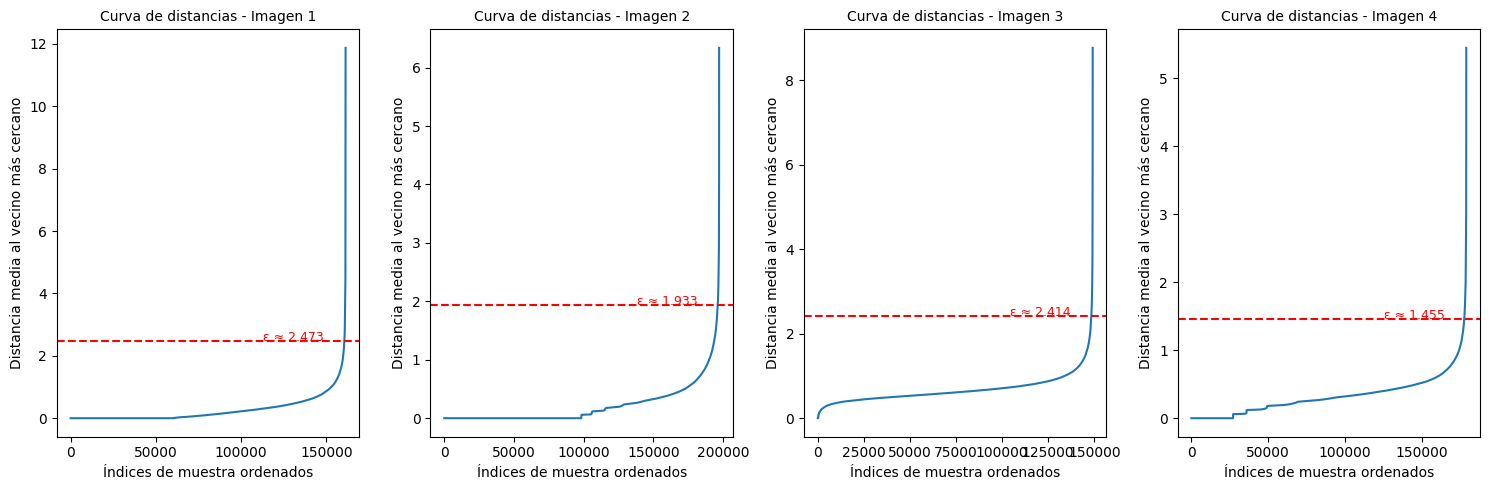

In [17]:
lista_pinturas =[img1, img2, img3, img4]
min_samples = 6
codo_DBSCAN(lista_pinturas, min_samples)

***
<span style="font-family:Cambria Math">

### HDBSCAN

</span>

In [18]:
# Entrena HDBSCAN y devuelve el modelo, número de clusters y Silhouette Score.

def entrenar_hdbscan(X: np.ndarray, min_samples):

    modelo = hdbscan.HDBSCAN(min_cluster_size=min_samples)
    labels = modelo.fit_predict(X)

    # Filtrar ruido (-1) y calcular número de clusters reales
    valid_labels = labels != -1  # Excluir puntos de ruido
    num_clusters = len(np.unique(labels[valid_labels]))

    # Evitar calcular silhouette_score si hay solo un cluster
    score = silhouette_score(X, labels) if num_clusters > 1 else -1

    return modelo, num_clusters, min_samples, score
# Selección de HDBSCAN con base en silhouette_score
def HDBSCAN_silhouette(X: np.ndarray, min_samples_list: list, metric: str ='euclidean', visuals: bool = True):
    # Estandarizar los datos
    X, scaler = estandarizar(X)

    # Paralelizar la búsqueda de hiperparámetros
    resultados = Parallel(n_jobs=-1)(
        delayed(entrenar_hdbscan)(X, min_samples) for min_samples in min_samples_list
    )

    # Extraer resultados
    modelos, num_clusters, min_samples_values, silhouette_scores = zip(*resultados)

    # Mostrar resultados
    if visuals:
      for k, min_samples, score in zip(num_clusters, min_samples_values, silhouette_scores):
          print(f"Modelo HDBSCAN K={k} Min Samples={min_samples} --> Silhouette Score: {score:.4f}")

    # Seleccionar el mejor modelo
    mejor_idx = np.argmax(silhouette_scores)
    mejor_modelo = modelos[mejor_idx]
    mejor_min_samples = min_samples_values[mejor_idx]

    # Obtener labels y filtrar ruido (-1)
    labels = mejor_modelo.labels_
    valid_labels = labels != -1  # Excluir ruido
    unique_labels = np.unique(labels[valid_labels])

    # Calcular "centroides" como el promedio de los core points por cluster
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])
    centroids = des_estandarizar(centroids, scaler)

    # Convertir a imagen RGB
    mejor_k = len(centroids)
    centroides_no_reshape = color.lab2rgb(centroids)
    centroids_RGB_img = centroides_no_reshape.reshape((1, mejor_k, 3))

    # Imprimir información del mejor modelo
    if visuals:
      print("**Mejor modelo HDBSCAN**")
      print(f"Número de clusters: {mejor_k} | Min Samples: {mejor_min_samples}")

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

***
<span style="font-family:Cambria Math">

### Aglomerativo

</span>

In [19]:
# Evalúa un modelo AgglomerativeClustering y retorna su desempeño.
def evaluar_modelo(X, linkage, k):
    modelo = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage=linkage)
    modelo.fit(X)
    labels = np.array(modelo.labels_)

    # Verificamos si hay más de un clúster para calcular silhouette_score
    score = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    return {'modelo': modelo, 'linkage': linkage, 'n_clusters': k, 'score': score}

#Busca el mejor modelo AgglomerativeClustering basado en silhouette_score.
def Agglomerative_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7, n_jobs: int = -1, visuals: bool = True):
    X, scaler = estandarizar(X)
    linkages = ['complete', 'average', 'ward']

    # Paralelizar evaluación de modelos
    resultados = Parallel(n_jobs=n_jobs)(
        delayed(evaluar_modelo)(X, linkage, k) for linkage in linkages for k in range(Kmin, Kmax + 1)
    )

    # Seleccionar el mejor modelo
    resultados_mejor = max(resultados, key=lambda r: r['score'])
    mejor_modelo = resultados_mejor['modelo']
    mejor_K = resultados_mejor['n_clusters']
    mejor_linkage = resultados_mejor['linkage']
    mejor_score = resultados_mejor['score']

    # Mensajería con los resultados
    if visuals:
      print("\n**Mejor modelo Agglomerative**")
      print(f"Linkage: {mejor_linkage}")
      print(f"Número de clusters: {mejor_K}")
      print(f"Mejor Silhouette Score: {mejor_score:.4f}")

    # Calcular "centroides" como el promedio de los puntos en cada cluster
    labels = np.array(mejor_modelo.labels_)
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique_labels])

    # Desestandarizar los centroides
    centroids = des_estandarizar(centroids, scaler)
    centroides_no_reshape = color.lab2rgb(centroids)
    centroids_RGB_img = centroides_no_reshape.reshape((1, mejor_K, 3))

    return centroids_RGB_img, mejor_modelo.labels_, centroides_no_reshape

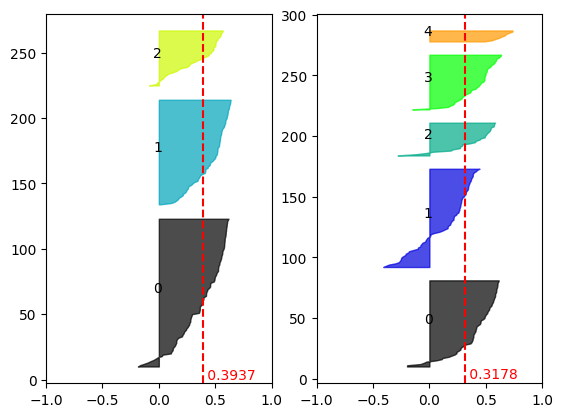

In [71]:
import matplotlib.cm as cm

def foo():
    img, rgb, lab = cargar_img_RGB_LAB_downsample(img3, factor=0.010)
    X = img_to_tabular(lab)
    X, scaler = estandarizar(X)

    # Mean Shift
    bw = estimate_bandwidth(X, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bw, bin_seeding=True).fit(X)
    ms_labels, ms_sil = ms.labels_, silhouette_samples(X, ms.labels_)
    
    # Aglomerativo
    agg = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average').fit(X)
    agg_labels, agg_sil = np.array(agg.labels_), silhouette_samples(X, agg.labels_)
    #print(silhouette_score(X, agg_labels))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    def plot_sil(ax, sil, labs, n):
        ax.set_xlim([-1, 1]); y = 10
        for i in range(n):
            s = np.sort(sil[labs == i]); l = len(s)
            ax.fill_betweenx(np.arange(y, y+l), 0, s, facecolor=cm.nipy_spectral(i/n), edgecolor=cm.nipy_spectral(i/n), alpha=0.7)
            ax.text(-0.05, y+0.5*l, str(i)); y += l+10
        avg_sil = np.mean(sil)
        ax.axvline(avg_sil, color='red', linestyle='--')
        ax.text(avg_sil, 0.5, f"{avg_sil: .4f}", color='red')
    
    plot_sil(ax1, ms_sil, ms_labels, len(np.unique(ms_labels)))
    plot_sil(ax2, agg_sil, agg_labels, 5)
    #print(agg_sil)

foo()

***
<span style="font-family:Cambria Math">

## Funciones que generan los grupos y paletas de colores

Una vez definidos los modelos sobre los que se va a probar cada pintura, se procede a correr los mejores representantes de cada modelo (escogidos por *score* de silueta) y se visualiza la representación de cada mejor agrupación en su versión en "Paleta", versión pixelada por cada color del centroide y finalmente con un gráfico en 2D utilizando t-SNE. Para facilidad de lectura del proyecto, se dejó el código con el parámetro del modelo con el mejor resultado.

También para las funciones que se crearon en esta sección se dejó la posibilidad de si incluir o no visualizaciones con la información de la corrido de los modelos, para solo correr la función con el propósito específico que queramos.

</span>

### Paleta de colores + Visualización por Centroides + t-SNE

In [30]:
#Genera los diferentes tipos de visualización de las pinturas
def generar_paleta(imgpath: str, factor: float = 0.05, modelo: str = 'KMeans', tSNE: bool = False, visuals: bool = True, retorno: bool = False):

    # Cargar imagen y convertir a formato tabular (LAB)
    img, rgb, lab = cargar_img_RGB_LAB_downsample(imgpath, factor=factor)
    lab_tabular = img_to_tabular(lab)

    # Diccionario de modelos de clustering
    modelos_clustering = {
        'KMeans': lambda X: KMeans_silhouette(X, visuals=visuals),
        'MeanShift': lambda X: MeanShift_silhouette(X, [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], visuals=visuals),
        'DBSCAN': lambda X: DBSCAN_silhouette(X, [1.2, 1.5, 1.8, 2.1, 2.4], [4, 5, 6], visuals=visuals),
        'HDBSCAN': lambda X: HDBSCAN_silhouette(X, [4, 5, 6], visuals=visuals),
        'Aglomerativo': lambda X:  Agglomerative_silhouette(X, visuals=visuals),
    }

    # Obtener el modelo y generar la paleta
    if modelo not in modelos_clustering:
        raise ValueError(f"Modelo '{modelo}' no reconocido. Usa uno de {list(modelos_clustering.keys())}")

    paleta, labels, centers = modelos_clustering[modelo](lab_tabular)

    if visuals:
        fig_cols = 4 if tSNE else 3
        fig, ax = plt.subplots(1, fig_cols, figsize=(15, 5))

        # Mostrar imágenes y paleta
        ax[0].imshow(img)
        ax[0].set_title("Imagen original")

        ax[1].imshow(paleta)
        ax[1].set_title("Paleta de colores")

        # Imagen segmentada con colores de la paleta
        img_segmented = centers[labels].reshape(rgb.shape)
        ax[2].imshow(img_segmented)
        ax[2].set_title("Imagen segmentada")

        print(f"Imagen reescalada a {rgb.shape[0]}x{rgb.shape[1]} píxeles")

    # Visualización t-SNE si está activado
    if tSNE:
        pca = PCA(n_components=2)
        x_reduced = pca.fit_transform(lab_tabular)

        tsne = TSNE(random_state=13, verbose=0)
        x_tsne = pd.DataFrame(tsne.fit_transform(x_reduced))

        markers = cycle(['o', '^', 'v', 'd', 's', 'x', '+', '*', '_', '.'])

        for i, marker in zip(range(len(centers)), markers):
            selections = x_tsne.iloc[np.where(labels == i)]
            ax[3].scatter(selections[0], selections[1], alpha=0.8, marker=marker, s=5, c=[centers[i]])
            x_mean, y_mean = selections.mean(axis=0)
            ax[3].text(x_mean, y_mean, str(i), fontdict={'weight': 'bold', 'size': 12, 'color': 'black'})

        ax[3].set_title("Distribución t-SNE de clusters")

    if visuals:
        plt.tight_layout()
        plt.show()

    if retorno:
        num_grupos = len(centers)
        X, scaler = estandarizar(lab_tabular)

        try:
            sil_score = silhouette_score(X, labels)
        except ValueError:
            sil_score = -1  # En caso de que haya un solo clúster o etiquetas inválidas

        return num_grupos, sil_score



***
<span style="font-family:Cambria Math">

### Selección del Mejor Modelo

Con el algoritmo anterior, debemos estar en la capacidad de poder conocer cual es el mejor valor de hiper-parámmetros para cada modelo. La siguiente función genera un `DataFrame` con un resumen de los resultados de cada modelo, para poder saber finalmente cuál es el ganador.
</span>

In [21]:
def generar_mejor_modelo(imgpath: str, factor: float ):
    modelos = ['KMeans', 'MeanShift', 'DBSCAN', 'HDBSCAN', 'Aglomerativo']

    params = {
        'Modelo': [],
        '# de Grupos': [],
        'Silhouette Score': []
    }

    for modelo in modelos:
        num_grupos, sil_score =  generar_paleta(imgpath, factor=factor, modelo=modelo, tSNE=False,visuals = False, retorno = True )
        params['Modelo'].append(modelo)
        params['# de Grupos'].append(num_grupos)
        params['Silhouette Score'].append(sil_score)

    df = pd.DataFrame(params)
    return df

***
<span style="font-family:Cambria Math">

## Ejecución y Resultados

Finalmente procedemos a generar el *DataFrame* para cada pintura, y visualizar los resultados del mejor modelo.
</span>

In [22]:
#print(generar_mejor_modelo(img1, factor= 0.075 ))

Modelo KMeans K=5 --> Silhouette Score: 0.5516
Modelo KMeans K=6 --> Silhouette Score: 0.5786
Modelo KMeans K=7 --> Silhouette Score: 0.5596
**Mejor modelo KMeans**
Número de clusters: 6
Imagen reescalada a 140x104 píxeles


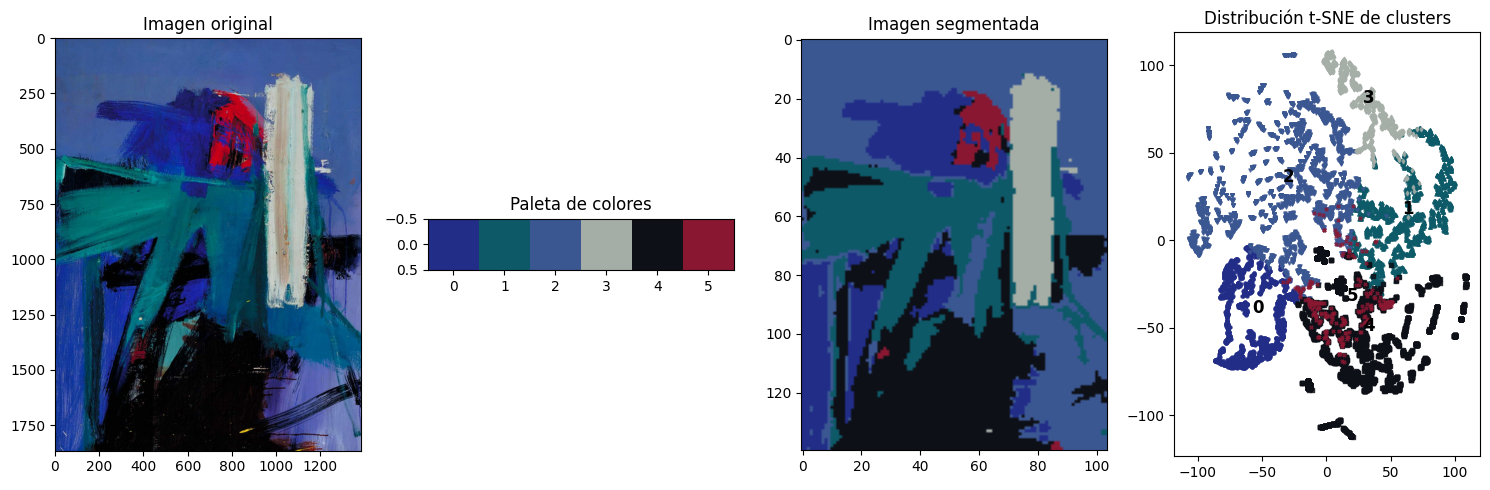

CPU times: user 3min 5s, sys: 279 ms, total: 3min 5s
Wall time: 38.1 s


In [34]:
%time generar_paleta(img1, factor=0.075, modelo = "KMeans", tSNE = True, visuals = True)

In [ ]:
%time generar_paleta(img1, factor=0.075, modelo = "Agg", tSNE = True, visuals = True)

In [24]:
#print(generar_mejor_modelo(img2, factor= 0.075 ))

Modelo KMeans K=5 --> Silhouette Score: 0.6269
Modelo KMeans K=6 --> Silhouette Score: 0.6363
Modelo KMeans K=7 --> Silhouette Score: 0.5704
**Mejor modelo KMeans**
Número de clusters: 6
Imagen reescalada a 228x138 píxeles


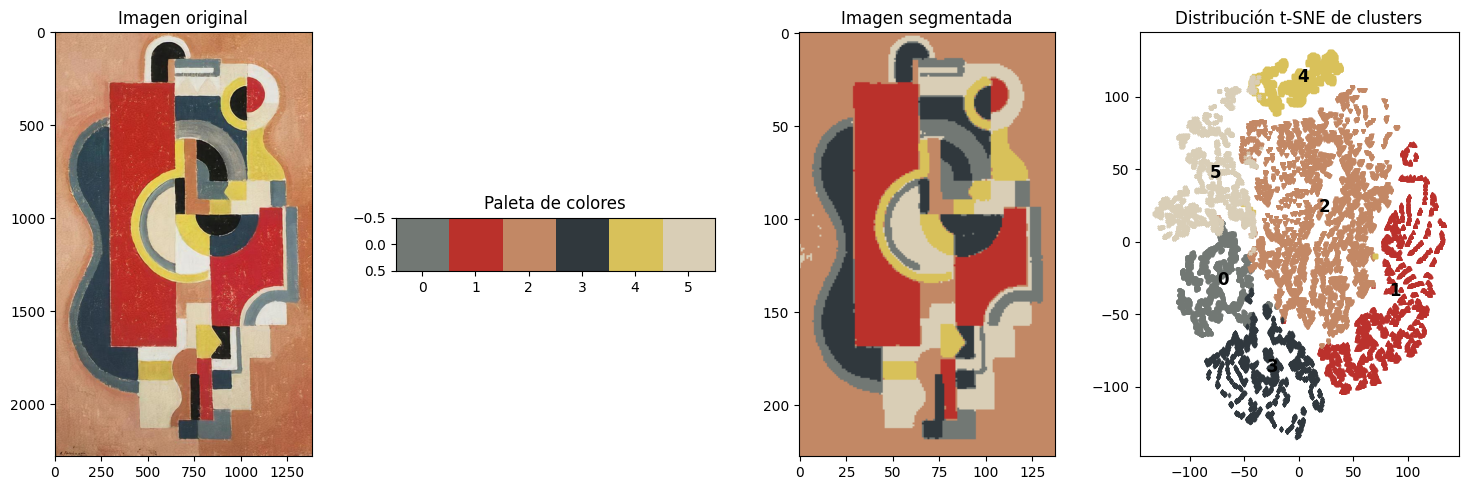

CPU times: user 5min 53s, sys: 73.7 ms, total: 5min 53s
Wall time: 1min 32s


In [25]:
%time generar_paleta(img2, factor=0.10, modelo = "KMeans", tSNE =True, visuals = True)

In [26]:
#print(generar_mejor_modelo(img3, factor= 0.075 ))

Modelo MeanShift K=3 Quantile=0.05 --> Silhouette Score: 0.3684
Modelo MeanShift K=2 Quantile=0.1 --> Silhouette Score: 0.3919
Modelo MeanShift K=2 Quantile=0.15 --> Silhouette Score: 0.3925
Modelo MeanShift K=2 Quantile=0.2 --> Silhouette Score: 0.3931
Modelo MeanShift K=2 Quantile=0.25 --> Silhouette Score: 0.3929
Modelo MeanShift K=2 Quantile=0.3 --> Silhouette Score: 0.3923
**Mejor modelo MeanShift**
Número de clusters: 2 Quantile=0.2
Imagen reescalada a 138x172 píxeles


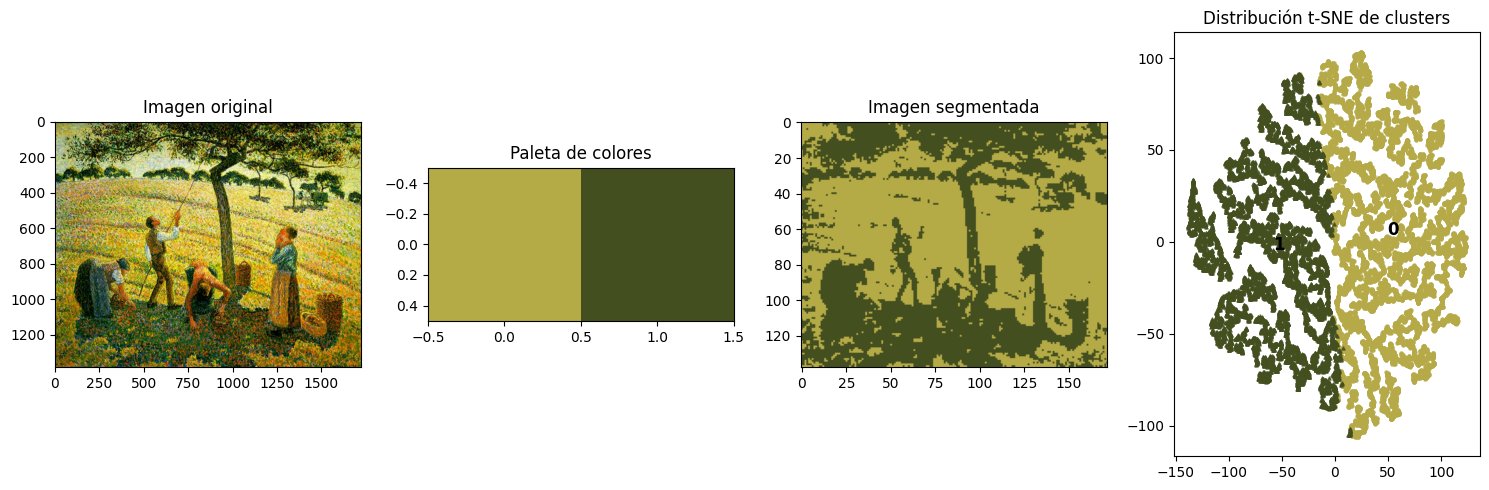

CPU times: user 4min 50s, sys: 93.5 ms, total: 4min 50s
Wall time: 1min 14s


In [27]:
%time generar_paleta(img3, factor=0.10, modelo = "MeanShift", tSNE = True, visuals = True)

In [28]:
#print(generar_mejor_modelo(img4, factor= 0.075 ))

Modelo MeanShift K=9 Quantile=0.05 --> Silhouette Score: 0.3273
Modelo MeanShift K=3 Quantile=0.1 --> Silhouette Score: 0.3790
Modelo MeanShift K=2 Quantile=0.15 --> Silhouette Score: 0.5280
Modelo MeanShift K=2 Quantile=0.2 --> Silhouette Score: 0.5291
Modelo MeanShift K=2 Quantile=0.25 --> Silhouette Score: 0.5172
Modelo MeanShift K=1 Quantile=0.3 --> Silhouette Score: -1.0000
**Mejor modelo MeanShift**
Número de clusters: 2 Quantile=0.2
Imagen reescalada a 138x207 píxeles


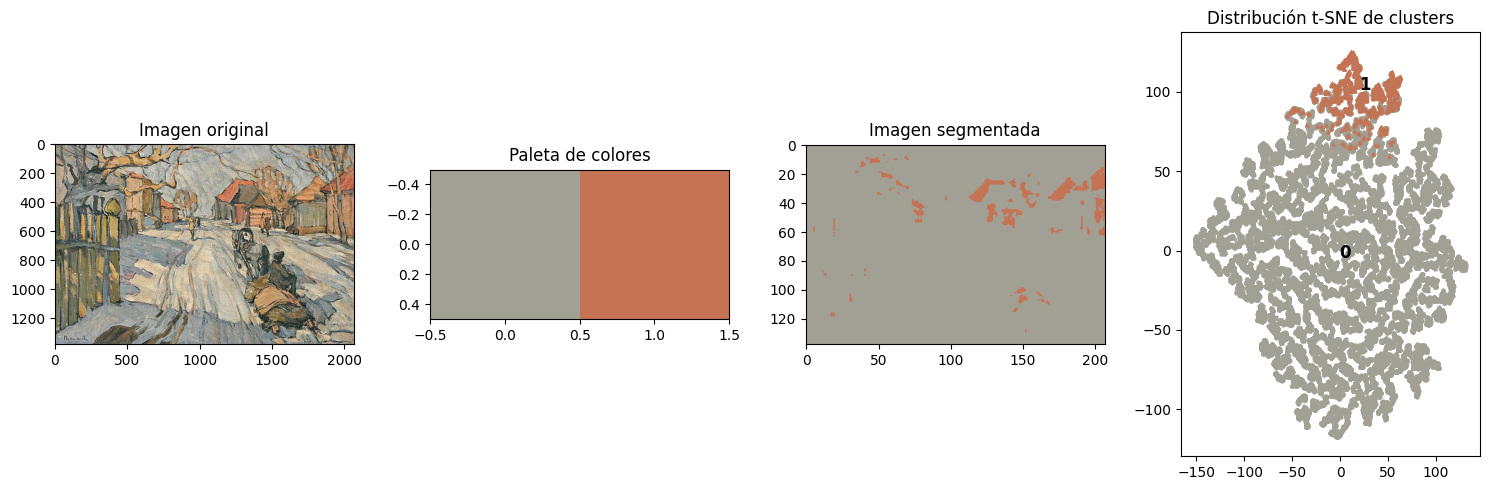

CPU times: user 5min 53s, sys: 90.6 ms, total: 5min 53s
Wall time: 1min 36s


In [29]:
%time generar_paleta(img4, factor=0.10, modelo = "MeanShift", tSNE = True, visuals = True)

***
<span style="font-family:Cambria Math">

## Conclusiones

Con este micro-proyecto se ha logrado probar una amplia variedad de modelos, recorriendo por diferentes tipos de algoritmos y diferentes valores de hiperparámetros, para poder lograr agrupar de la manera más efectiva las pinturas seleccionadas. En su mayoría, se observa que KMeans y MeanShift son algoritmos con un buen desempeño para esta tarea, sin embargo, esto depende mucho del tipo de imagen / pintura que se reciba como *input*. En algunas, pinturas como la 3 y la 4 se obtuvo un número reducido de *clusters* pero aumentarlo, como se puede ver en la tabla de resultados de cada imagen, iría en detrimento del rendimiento medido a partir del *score* de silueta.

Por otro lado, otras heurísticas como el codo para DBSCAN permitieron definir el rango de búsqueda de estos hiperparámetros, con el objetivo de poder lograr el representante más adecuado para cada tipo de modelo.

</span>

***
<span style="font-family:Cambria Math">

## Referencias

</span>

---
- https://en.wikipedia.org/wiki/CIELAB_color_space#Perceptual_differences
- https://es.wikipedia.org/wiki/Espacio_de_color_Lab
- https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2lab
- https://stackoverflow.com/questions/52459146/what-should-be-the-input-to-skimage-color-rgb2lab